### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Friday, Feb 19th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

~~1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.~~

~~2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*~~

~~3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.~~

~~4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*~~

~~5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?~~

~~6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.~~

~~7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?~~

8~~) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.~~

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [13]:
!pip install numdifftools

In [ ]:
# BS - I was getting an error that numdifftools was not available
# even after install and reopening my notebook, so I had to look up
# a slightly fancier install.

import sys
sys.executable
sys.path

!{sys.executable} -m pip install numdifftools

### Solution

In [15]:
### PART 1

### BS - First, the packages and data bookeeping for the assignment

# BS - import the things
import numpy as np
from scipy import optimize
from scipy.stats import norm
from scipy.stats import laplace
from matplotlib import pyplot as plt
import numdifftools as nd
%matplotlib inline
%config InlineBackend.figure_format='retina'


# BS - import the data using numpy
data = np.load('/Users/smithwj/Box Sync/Astrostatistics/astr_8070_s21/coursework/homeworks/hw_data/hw3_data_1.npy')
# BS - Data is a 100 x 2 array

In [7]:
### ACTUAL PART 1

# BS - make arrays for each the data points and their associated uncertainties
data_vals = data[:,0]
data_uncerts = data[:,1]

# BS - calculate the means using the formula in the cell below from lecture 5
analytic_mean = np.sum(data_vals / data_uncerts**2) / np.sum(1 / data_uncerts**2)
analytic_uncert = np.sum(1 / data_uncerts**2)**(-1/2)

print("The mean from the analytic result is: %.5f" % analytic_mean)
print("The standard error from the analytic result is: %.5f" % analytic_uncert)

The mean from the analytic result is: 3.91799
The standard error from the analytic result is: 0.09481


For heteroskedastic distributions: 

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

and 

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}$$

### Part 2

The formula for a Gaussian is: 

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)$$

And to find the maximum likelihood for a set of data points, we take the product of the likelihood for each point: 

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

To turn this into a more manageable minimization problem, we can take the log (to make the product more manageable) and make it negative (to turn a maximization problem into a minimization problem)

$$-\ln(L) = -\ln \left(\prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right)\right) $$

Which is the function I am going to minimize here.

In [8]:
def gaussian (mu, sigma, x_i):
    
    #BS write out the Gaussian function
    
    p_fit = (1 / (sigma * np.sqrt(2*np.pi))) * np.exp((-(x_i - mu)**2) / (2*sigma**2))
    
    
    #BS - return the negative log of the product of each likelihood
    
    return -np.log((np.prod(p_fit)))

# BS - make a lambda function for likelihood ease of use
lkhd = lambda beta : gaussian(mu=beta, sigma=data_uncerts, x_i=data_vals)


# BS - take a guess at mu
beta = 3

#BS - call the optimization function to find the minimum
max_lkhd = optimize.fmin(lkhd, beta)

print("The mean value that gives us the maximum value of the likelhood function is: %.5f" % max_lkhd)

Optimization terminated successfully.
         Current function value: 147.257863
         Iterations: 16
         Function evaluations: 32
The mean value that gives us the maximum value of the likelhood function is: 3.91802


NOTE: I wasn't sure if this was correct until our office hours conversation because I was working through how differing $\sigma$'s worked. So I also did it this way that started further in the derivation. I also found the likelihood through:

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}$$


So now I do what i did above, but with a slightly different python function:

In [9]:
def gaussian2 (mu, sigma_i, x_i):
    
    #BS - definition of the log-likelihood function. I just kind of ignored the constant, and 
    # this optimization function worked out without the negative. With the negative, it goes
    # off to -inf instead of converging. I'm not sure why
    
    ln_L = np.sum((x_i - mu)**2 / (2 * sigma_i**2))
    
    return ln_L

# BS - lambda function helper
likelihood = lambda beta : gaussian2(mu = beta, sigma_i = data_uncerts, x_i = data_vals)

# BS - take a guess
beta = 10

# BS - optimize! Find that min!
max_likelihood = optimize.fmin(likelihood, beta)

print("The mean value that gives us the maximum value of the likelhood function (done my second way) is: %.5f" % max_likelihood)



Optimization terminated successfully.
         Current function value: 43.162545
         Iterations: 20
         Function evaluations: 40
The mean value that gives us the maximum value of the likelhood function (done my second way) is: 3.91797


In [30]:
### NOTE: AT THIS POINT, THE ABOVE IS WHAT I HAVE COMPLETED FOR PART 2
### BELOW I KEPT SOME OF THE OTHER THINGS I WAS PLAYING WITH JUST FOR 
### REFERENCE EVEN THOUGH IT DOESN'T QUITE WORK AND THE CODE IS WAY 
### CLUNKIER (AND COMMENTED OUT SO IT DOESN'T ACCIDENTALLY INTERFERE).

# BS - Here I wasn't sure if I could solve the Gaussian as a one
# parameter model, so I tried to solve it as a two parameter model for
# mu and sigma. The optimization function doesn't converge. I also think
# this is wrong because solving this as a two parameter model conflates the
# two different sigmas, one which is the error on each of the measurements, 
# and one which is the sigma of the model we are fitting to the distribution
# of measurements

'''
def gaussian (mu, sigma, x_i):
    
    x_i = np.array(x_i)

    p_fit = 1 / ( (sigma * np.sqrt(2*np.pi)) * np.exp((-(x_i - mu)**2) / (2*sigma**2)))
    #print('\n', mu, '\n', sigma, '\n')
    
    #print(1 / (sigma * np.sqrt(2*np.pi)), '\n')
    #print(np.exp((-(x_i - mu)**2) / (2*sigma**2)), '\n')
    
    #getting ridiculously low values for e ^ stuff, basically 0, for sigma = 0.1. Getting e ^-24 for sigma = 1
    #when multiplying these together, product -> 0
    
    #print(p_fit)
    #print(np.prod(p_fit))
    
    #Product gets so big, np.array becomes inf. and log cant read inf as an array
    
    #print(np.log(np.prod(p_fit), "\n"))
    
    return -np.log((np.prod(p_fit)))


lkhd = lambda beta : gaussian(mu=beta[0], sigma=beta[1], x_i=data_vals)


#testpfit = gaussian(5, 1, data_vals)
testpfit2 = gaussian(10, 1, data_vals)
#print(testpfit2)
beta = [3, .5]

max_lkhd = optimize.fmin(lkhd, beta)

print(max_lkhd)
'''

[1.875    0.565625]


/Users/smithwj/anaconda3/envs/astr8070/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/smithwj/anaconda3/envs/astr8070/lib/python3.8/site-packages/scipy/optimize/optimize.py:734: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


In [44]:
### BS - second way

### Here I was trying to ind the likelihood by 
### creating a normal distribution for each point
### in the data (given the measured mu and sigma)
### and multiplying them as we did with L1, L2, and L3
### in the lecture notebook. From that, I could find the
### max likelihood. Trying to multiply this many
### distributions rapidly pushes the computer past
### its limits, though.

'''
xgrid = np.linspace(-5, 10, 1000)

all_ls = []

for i in range(len(data_vals)):
    L = norm.pdf(xgrid, data_vals[i], data_uncerts[i])
    #plt.plot(xgrid, L)
    all_ls.append(L)
    
L_tot = np.prod(all_ls, axis=1)

L_tot_test = all_ls[0]*all_ls[1]*all_ls[2]*all_ls[3]*all_ls[4]*all_ls[5]*all_ls[6]*all_ls[7]*all_ls[8]*all_ls[9]

#print(L_tot)

#get multiplications that blow up (down?) to zero
'''

### Part 3

The Fisher Uncertainty on the mean can be found by: 

$$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

Because we have heteroskedastic uncertainties, we *cannot* just follow this derivation to

$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}$$

Instead, we can approximate this second derivative numerically and directly. First make an array of possible $\mu$ values and their $ln$-likelihoods. From that, we can take the second derivative as we did in lecture 5 to find $\frac{d^{2}ln(\mu)}{d\mu^{2}}$. From that, some arithmetic gets us to $\sigma_{\mu}$

In [10]:
# PART 3 - Fisher Uncertainty

# BS - make a grid of mu's
mu_grid = np.linspace(2, 6, 1000)

# BS - create an array for likelihoods for each mu
likelihoods = []


#BS - for each mu, calculate the -ln(likelihood) and append it

for i in range(len(mu_grid)):
    
    likelihood = gaussian2(mu_grid[i], data_uncerts, data_vals)
    
    likelihoods.append(likelihood)
    
# BS - bookkeeping, keep everything in numpy
likelihoods = np.array(likelihoods)

# BS - find our d^2 L
sigma_mu = np.diff(likelihoods, n=2)

# BS - find our d mu^2
sigma_mu /= (mu_grid[1]-mu_grid[0])**2 #BS - Note: /= is divide and reassign (haven't seen that one before but makes sense)

# BS - we don't need to multiply by -1 in this case
#sigma_mu *= -1

# BS - take our 1 / sqrt and take the first element
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.5f" % sigma_mu)


Fisher matrix error on estimated mean is 0.09481


### Part 4

In [11]:
### BOOTSTRAP


def bootstrap_means(sample_ary, sample_uncerts, N):
    
    '''The bootstrap_means function takes the sample data, the 
    sample uncertanties, and a number for the number of bootstraps
    to calculate and returns
    
    means - an array with the means of each of the bootstrap
    samples
    
    realiz - a 2-D array of the raw data for all of the
    bootstrap realizations
    
    realiz_uncerts - a 2-D array of the raw data for every 
    uncertainty associated with each realization measurement
    '''
    
    # BS - arrays to store everything
    means = []
    realiz = []
    realiz_uncerts = []
    
    
    # BS - outer loop. Make N bootstrap samples
    
    for i in range(N):
        
        # BS - arrays for each full bootstrap realization and 
        # uncertainty. One per inner loop
        vals = []
        val_uncerts = []
        
        
        # BS - inner loop - make each individual bootstrap. 
        # Each inner loop runs over the length of the data array
            
        for j in range(len(sample_ary)):
            
            # BS - pick a random integer that represents an
            # index choice of the data point to be chose
            rand_idx = np.random.randint(0, len(sample_ary))
            
            # BS - pick the random value and its uncertainty
            # from the data
            rand_val = sample_ary[rand_idx]
            rand_uncert = sample_uncerts[rand_idx]
            
            # BS - append each to the outer loop
            vals.append(rand_val)
            val_uncerts.append(rand_uncert)
        
        # BS - Back to the outter loop - append the bootstrap
        # realization and uncertainty to the main array
        realiz.append(vals)
        realiz_uncerts.append(val_uncerts)
        
        # BS - calculate the mean of the realization and append
        mean = np.mean(vals)
        means.append(mean)
        
    # BS - Make it numpy
    means = np.array(means)
    realiz = np.array(realiz)
    realiz_uncerts = np.array(realiz_uncerts)
    
    return means, realiz, realiz_uncerts

means, realizations, realiz_uncertainties = bootstrap_means(data_vals, data_uncerts, 1000)


### Part 5

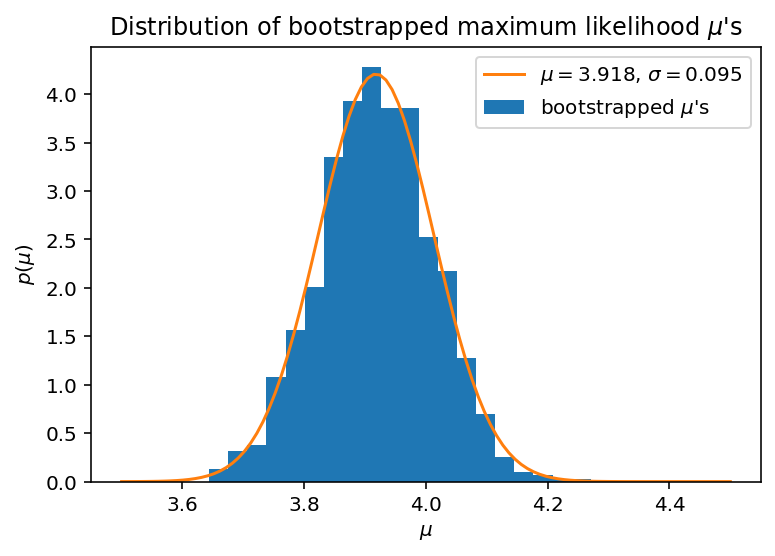

In [12]:
mu_bootstrapped = []

for i in range(len(realizations)):
    
    # BS - lambda function helper, do for each realization in the loop
    likelihood = lambda beta : gaussian2(mu = beta, sigma_i = realiz_uncertainties[i], x_i = realizations[i])

    # BS - take a guess
    beta = 10

    # BS - optimize! Find that min!
    max_likelihood = optimize.fmin(likelihood, beta, disp=False)
    
    # BS - append the max likelihood for this realization
    mu_bootstrapped.append(max_likelihood[0])

# BS - create the distribution and grid to overlay
analytic_dist = norm(analytic_mean, analytic_uncert)
xgrid=np.linspace(3.5, 4.5, 100)


# BS - plot both
plt.hist(mu_bootstrapped, bins="scott", density=True, label=r"bootstrapped $\mu$'s")
plt.plot(xgrid, analytic_dist.pdf(xgrid), label=r"$\mu = %.3f$, $\sigma = %.3f$" % (analytic_mean, analytic_uncert))
plt.xlabel(r"$\mu$")
plt.ylabel(r"$p(\mu)$")
plt.title(r"Distribution of bootstrapped maximum likelihood $\mu$'s")
plt.legend()
plt.show()

#BS - Do they agree? - yeah, I'd say so...


### Part 6

#### Laplace distribution

The Laplace distribution is given by: 

$$ f(x\mid\mu,\Delta) = \frac{1}{2\Delta} \exp \left( -\frac{|x-\mu|}{\Delta} \right) $$

To minimize, I take the $-ln$ of the product of each individual likelihood, as above.


In [13]:
# BS - make the function

def laplacian(mu, delta, x_i):
    
    p = 1 / (2*delta) * np.exp(-(np.absolute(x_i - mu)) / delta)
    
    return -np.log(np.prod(p))


# BS - use the handy lambda function
lkhd_lap = lambda beta : laplacian(mu=beta[0], delta=beta[1], x_i=data_vals)

# BS - two parameter fit, so guesses for [mu, delta]
beta = [3, 1]

# BS - optimize function
max_lkhd_lap = optimize.fmin(lkhd_lap, beta)

print("The max likelihood location is %.3f, and the max likelihood scale is %.3f" % (max_lkhd_lap[0], max_lkhd_lap[1]))



Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 54
         Function evaluations: 100
The max likelihood location is 4.086, and the max likelihood scale is 0.882


#### Part 7

The AIC is given by: 

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1} $$

Where:
<br>
$L^{0}(M)$ is the maximum likelihood of the model
<br>
$k$ is the number of model parameters
<br>
$N$ is the number of data points

First, I have to find those actual maximum likelihoods for each model:

In [16]:
# BS - find the maximum likelihood for each model:

# BS - first, a grid
xgrid = np.linspace(0, 6, 1000)

# BS - create each distribution using the loc and scale parameters given
gauss_dist = norm(analytic_mean, analytic_uncert)
laplace_dist = laplace(max_lkhd_lap[0], max_lkhd_lap[1])

# BS - get the probability densities for each
p_gauss = gauss_dist.pdf(xgrid)
p_laplace = laplace_dist.pdf(xgrid)

# BS - for gauss, find the max propability density
gauss_sort = np.argsort(p_gauss)
max_idx_g = gauss_sort[-1]
max_p_gauss = p_gauss[max_idx_g]

# BS - for laplace, find the max probability density
laplace_sort = np.argsort(p_laplace)
max_idx_l = laplace_sort[-1]
max_p_laplace = p_laplace[max_idx_l]



Now I can make an AIC function and call it for each:

In [17]:
def AIC(max_like, param_num, data_pt_num):
    
    '''AIC function takes three arguments, the maximium likelihood for a distribution,
    the number of parameters in the model, and the number of data points to fit the model
    
    returns - AIC goodness of fit'''
    
    AIC = -2 * np.log(max_like) + 2*param_num + (2*param_num*(param_num+1)) / (data_pt_num - param_num - 1)
    
    return AIC

# BS - call function for each.
AIC_gauss = AIC(max_p_gauss, 1, 100)
AIC_lap = AIC(max_p_laplace, 2, 100)

print("The AIC value of the Gaussian fit is %.5f, and the AIC value of the Laplacian fit is %.5f" % (AIC_gauss, AIC_lap))
print("The Gaussian fit has the lower value and is the preferred choice")



The AIC value of the Gaussian fit is -0.83257, and the AIC value of the Laplacian fit is 5.26336
The Gaussian fit has the lower value and is the preferred choice


#### Part 8

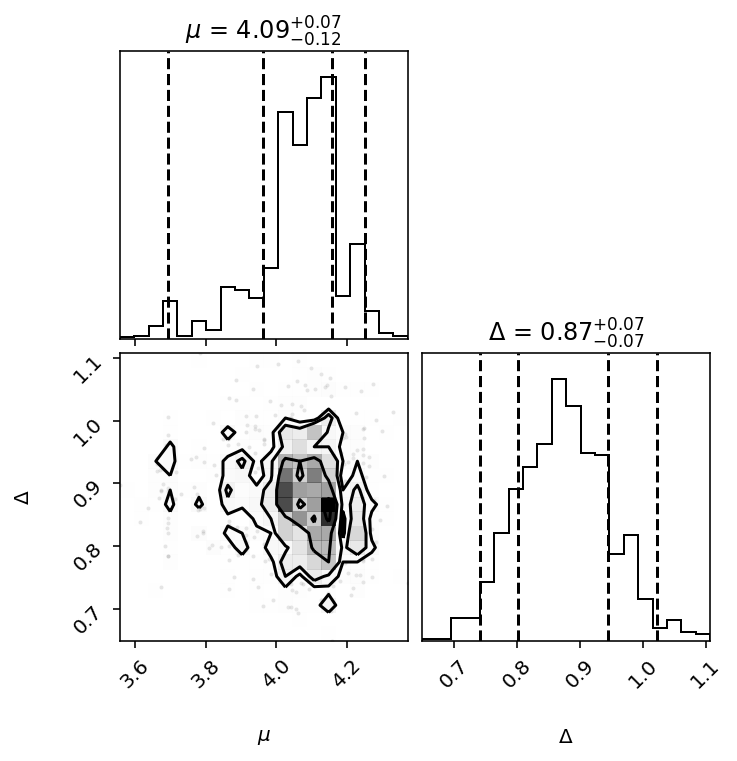

In [18]:
## Part 8

import corner

# BS - create arrays to save each mu and delta for each bootstrap realization
laplacian_mus = []
laplacian_deltas = []

# BS - loop through each realization and find the maximum likelihood fit
for i in range(len(realizations)):
    
    lap_likelihood = lambda lp_beta : laplacian(mu = lp_beta[0], delta = lp_beta[1], x_i = realizations[i])
    
    # BS - guess, same for each loop
    lp_beta = [3, 1]
    
    max_likelihood_laplacian = optimize.fmin(lap_likelihood, lp_beta, disp=False)
    
    max_likelihood_laplacian = np.array(max_likelihood_laplacian)
    
    # BS - append the mu to the mu array, and the delta to the delta array
    laplacian_mus.append(max_likelihood_laplacian[0])
    laplacian_deltas.append(max_likelihood_laplacian[1])
  
 # BS - bookeeping, numpy array conversion
laplacian_mus = np.array(laplacian_mus)
laplacian_deltas = np.array(laplacian_deltas)

#BS - stack and transform the data for proper corner plot
lap_data = np.vstack([laplacian_mus, laplacian_deltas])
lap_data = np.transpose(lap_data)

#BS - make the corner plot
fig = corner.corner(lap_data, labels=[r"$\mu$", r"$\Delta$"], quantiles=[0.025, 0.16, 0.84, .975], show_titles=True)

If we define the Fisher Matrix as: 

$$ F_{jk} = - \frac{d^2}{d\theta_j} \frac{\ln L}{d\theta_k} \Biggr\rvert_{\theta=\hat \theta}$$

We can calculate the covariance matrix:

$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

Where each element of the diagonal gives us the marginal error for each of our parameters $\theta$. In this case, we have a two-parameter model $\theta = \theta(\mu, \Delta)$. Using numdifftools, we can take the second derivatives of our likelihood function with respect to each of these parameters, assembled in a $2 \times 2$ matrix called the Hessian matrix. From this Hessian, we can invert and square root, giving us the covariance matrix, of which the diagonals will give us uncertanties in $\mu$ and $\Delta$

In [37]:
## PART 9

# BS - use mu and delta from best fit as args for beta 
beta = (max_lkhd_lap[0], max_lkhd_lap[1])

# BS - call the Laplacian function from above to
# calculate the Hessian starting with mu and lambda 
H = nd.Hessian(laplacian)(beta[0], beta[1], x_i = data_vals)

# BS - invert and square root
sigma_laplace = np.linalg.inv(H)**0.5

print(sigma_laplace)

# BS - ADDITIONAL COMMENTS
# I'm not particularly confident I calculated the Hessian correctly. These few line of code
# understate the hours of tinkering I did with numdifftools trying to figure out
# the mechanics of how this Hessian object works with multiple test functions and parameters
# even though I think I understand what is going on theoretically pretty well. 
# (I spent most of my Friday afternoon deconstructing these simple examples in excrutiating detail: 
# https://numdifftools.readthedocs.io/en/latest/reference/generated/numdifftools.core.Hessian.html)
# The above was literally the only thing I could come up with code-wise that didn't result in 
# an error. I still can't figure out why I am getting a 1 element array instead of a 2 x 2.

[[0.19762189]]
